# Explore LFP Data
<p>created: Jan 28, 2023 <br>
last modified: Feb 16, 2024 </p>
<p>
This is an exploratory notebook examining some example LFP data. The power spectral density of the signal is computed and plotted along with the signal. Additionly, the Spectral Parameterization method is applied.

</p>

#### Set-up

In [3]:
# general
from scipy.io import loadmat
# from neo.io import NixIO
import matplotlib.pyplot as plt
import numpy as np

# lab 
from neurodsp.utils import create_times
from neurodsp.spectral import compute_spectrum
from specparam import SpectralGroupModel
from specparam.plts.spectra import plot_spectrum
from specparam.plts.annotate import plot_annotated_model

# project
import sys
sys.path.append('../../code')
from paths import PROJECT_PATH, EXTERNAL_PATH
from info import SESSIONS, FS

In [13]:
# select example channel
CHAN = 3 

In [12]:
# load data
data_in = loadmat((fr'{EXTERNAL_PATH}\V1_v4_1024_electrode_resting_state_data\data\{SESSIONS[0]}/LFP/NSP1_array2_LFP.mat'))
print(data_in.keys())

# get lfp data 
lfp = data_in['lfp']

# create time-vector
n_seconds = lfp.shape[0]/FS
time = create_times(n_seconds, FS)
print(time.shape)

# show
print(lfp.shape)
print(f"N channels: \t\t{lfp.shape[1]}")
print(f"Signal duration: \t{n_seconds} (s)")

dict_keys(['__header__', '__version__', '__globals__', 'lfp', 'channel_names', 'channel_ids', 'file_origin', 'connector_ID', 'connector_pinID', 'nev_dig_factor', 'nb_sorted_units', 'nev_hi_freq_order', 'nev_hi_freq_type', 'nev_lo_freq_order', 'nev_lo_freq_type', 'nsx_hi_freq_order', 'nsx_lo_freq_order', 'nsx_hi_freq_type', 'nsx_lo_freq_type', 'description', 'nsx', 'Electrode_ID', 'NSP_ID', 'within_NSP_electrode_ID', 'Array_ID', 'within_array_electrode_ID', 'cortical_area', 'schematic_X_position', 'schematic_Y_position'])
(78644,)
(78644, 64)
N channels: 		64
Signal duration: 	157.288 (s)


#### Spectral Analysis

(78644,)


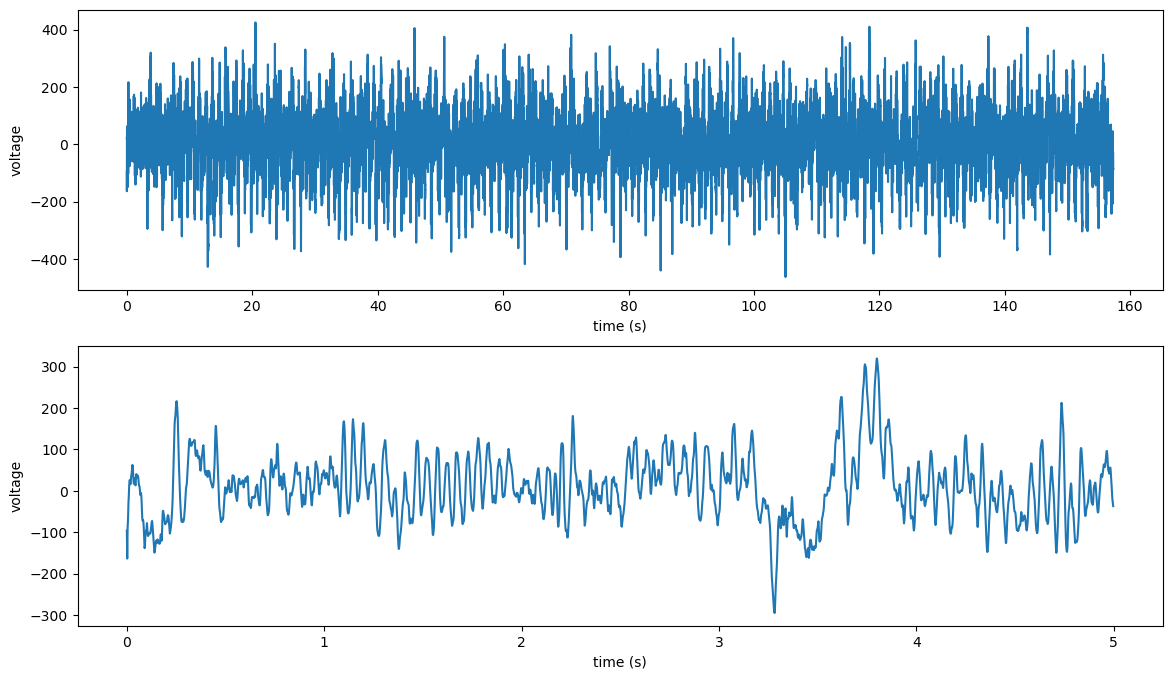

In [14]:
# get signal for an example channel
signal = lfp[:,CHAN]
print(signal.shape)

# plot example signal
fig, (ax1, ax2) = plt.subplots(2,1, figsize=[14,8])
ax1.plot(time, signal)

# plot snippet of signal
time2plot = 5 # sec
ax2.plot(time[:time2plot*FS], signal[:time2plot*FS])

# label plots
for ax in [ax1, ax2]:
    ax.set(xlabel='time (s)', ylabel='voltage')


In [8]:
## save to external drive
#np.save(PROJECT_PATH + '/temp', signal)

In [34]:
def plot_signal_and_power(time, signal, freq, spectrum, title='', logscale=False, xlims=None):
    '''
    Plot time-series and corresponding power spectum

    Parameters
    ----------
    time : 1D array, float
        time-vector for signal
    signal : 1D array, float
        time-series e.g. LFP or EEG
    freq : 1D array, float
        frequency-vector for spectrum
    spectrum : 1D array, float
        power spectrum of signal
    title : str, optional
        figure title. The default is ''.
    logscale : bool, optional
        whether to plot the spectrum in log-log space. The default is False.
    xlims : 1D array (len=2), optional
        x-axis limits for time-series plot ([lower_limit, upper_limit]). 
        The default is None.

    '''
    # create figure
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=[12,4], gridspec_kw={'width_ratios': [3, 1]}, constrained_layout=True)
    fig.suptitle(title)

    # plot signal
    ax1.set(xlabel='time (s)', ylabel='voltage (au)', title='Time-series')
    ax1.plot(time, signal)
    if xlims:
        ax1.set_xlim(xlims)
        
    # plot spectra
    ax2.set(xlabel='frequency (Hz)', ylabel='power (au)', title='Power Spectral Density')
    ax2.plot(freq, spectrum);
    ax2.set_xlim([.1,200])
    if logscale:
        ax2.set(xscale='log', yscale='log')

    

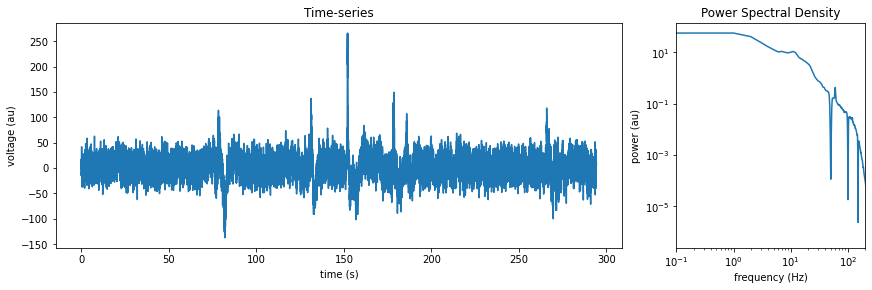

In [35]:
# compute power spectrum
freq, psd = compute_spectrum(signal, FS)

# plot
plot_signal_and_power(time, signal, freq, psd, logscale=True)

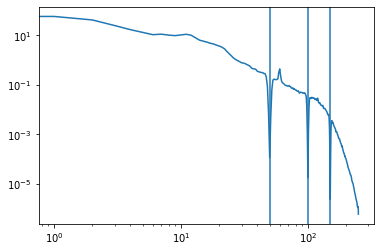

In [36]:
# examine pre-processing (band-pass )
fig, ax = plt.subplots()
ax.loglog(freq, psd)
ax.axvline(50)
ax.axvline(100)
ax.axvline(150)

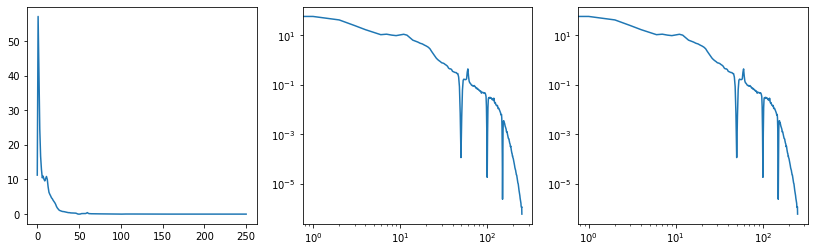

In [37]:
# log plotting explanation
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[14,4])

ax1.plot(freq, psd)

ax2.plot(freq, psd)
ax2.set_xscale('log')
ax2.set_yscale('log')

ax3.loglog(freq, psd)


## Spectral Parameterization

In [38]:
# compute power spectrum
freq, psd = compute_spectrum(signal, FS, f_range=[1,45])

In [42]:
# parameterize
fm = FOOOF(min_peak_height=0.05, aperiodic_mode='knee', peak_threshold=2)
fm.fit(freq, psd)


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



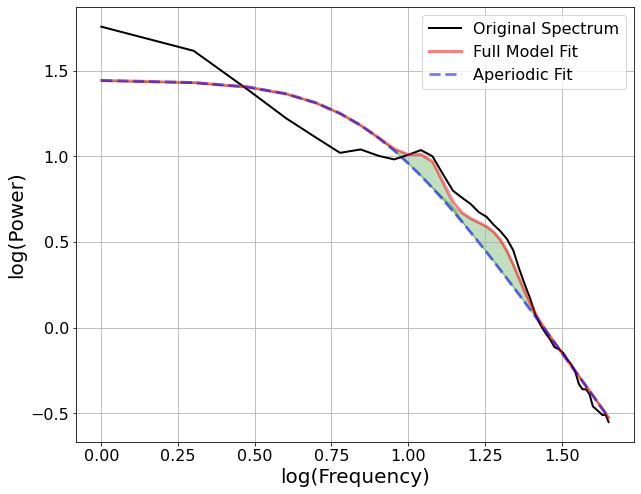

In [45]:
# plot specparam results
fm.plot(plot_peaks='shade', plt_log=True)
# fm.plot(plt_log=True)

In [44]:
fm.print_results()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 45 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     3.6582, 163.3525, 2.5274                                     
                                                                                                  
                                       2 peaks were found:                                        
          

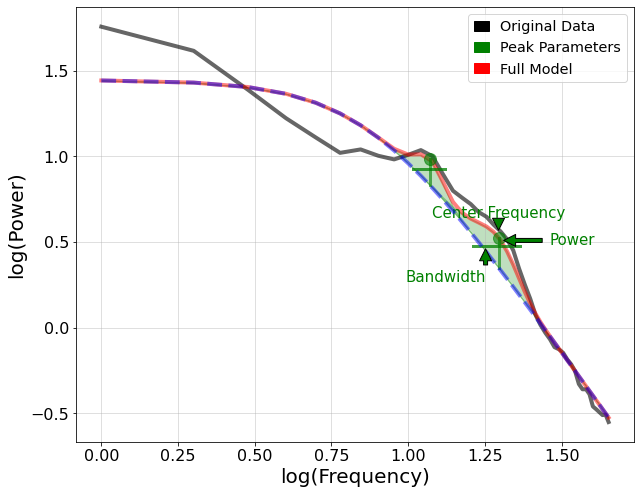

In [51]:
# Plot an annotated version of the power spectrum model
plot_annotated_model(fm, annotate_aperiodic=False, plt_log=True)

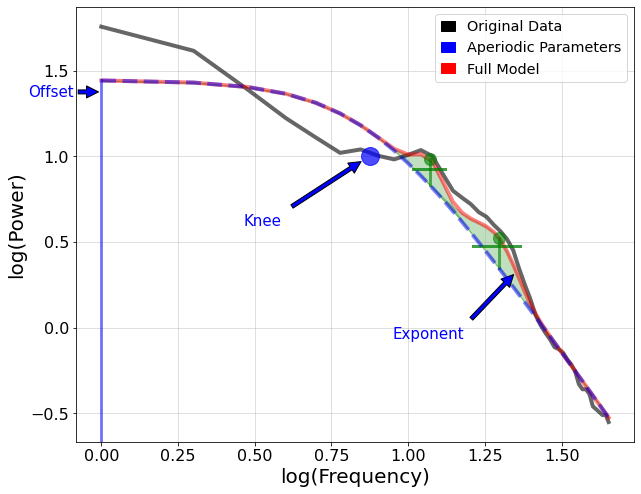

In [50]:
# Plot an annotated version of the power spectrum model
plot_annotated_model(fm, annotate_peaks=False, plt_log=True)